In [1]:
import numpy as np
from utils.database_repository import DataRepository
from utils.objects import *
import json
from matplotlib import pyplot as plt
from scipy.stats import norm
import statistics

In [2]:
repository = DataRepository()

Connected to MySQL Server version  5.7.40-43-log


In [3]:
def getProfilerData(id):
    query = "SELECT e.StartTime, e.Duration, e.Runs, d.Name as 'dutName', p.Name as 'profilerName', t.Name as 'testCaseName', r.Value FROM Experiment AS e JOIN Dut AS d ON e.DutId = d.id JOIN Profiler as p ON e.ProfilerId=p.Id JOIN TestCase as t ON e.TestCaseId = t.Id JOIN RawData as r ON e.id = r.ExperimentId WHERE e.profilerId = "+str(id)
    data = repository.query_all(query);
    return data

def getDut(data, dut):
    return [x for x in data if x[3] == dut]

In [4]:
HardwareMeasure = getProfilerData(5)
HardwareMonitor = getProfilerData(3)

In [5]:
# SurfaceBook = [x for x in data if x[3] == "SurfaceBook"]
# Surface4Pro = [x for x in data if x[3] == "Surface4Pro"]
# PowerKomplett = [x for x in data if x[3] == "PowerKomplett"]

In [6]:
def getEnergyConsumptionClamp(lst):
    return [ json.loads(x[6])["TrueRMS"] for x in lst ]

def getEnergyConsumptionHW(lst):
    return [ json.loads(x[6])[0]["cpuPowerPacketTotalJ"] for x in lst ]

def getEnergyConsumptionRapl(lst):
    start = [[ json.loads(x[6])["CoreStartInJoules"] for x in lst ]][0]
    stop = [[ json.loads(x[6])["CoreStopInJoules"] for x in lst ]][0]
    zipped = zip(start,stop)
    return [y-x for x,y in zipped]

def getEnergyConsumptionIntel(lst):
        return [ json.loads(x[6])["CumulativeProcessorEnergyInJoules"] for x in lst ]


def PlotEnergyConsumptionCLamp(dut):
    data = getEnergyConsumptionClamp(dut)
    #data.sort()
    plt.plot(data, 'k', linewidth=1)
    plt.show()

def PlotEnergyConsumptionHW(dut):
    data = getEnergyConsumptionClamp(dut)
    #data.sort()
    plt.plot(data, 'k', linewidth=1)
    plt.show()

def getTestcase(lst,case):
    #TestCaseIdle
    return [x for x in lst if x[5] == case ]

def getTestcaseNames(lst):
    return set([x[5] for x in lst])

def PlotEnergyConsumptionPerTestcase(dut, sort = False):
    cases = getTestcaseNames(dut)
    lines = {}
    for case in cases:
        lines[case] = getEnergyConsumptionHW(getTestcase(dut,case))
        data = getEnergyConsumptionHW(getTestcase(dut,case))
        if (sort):
            data.sort()
        plt.plot(data,label = case)
    plt.legend()
    plt.show()

def getTestCaseEnergyStats(lst):
    return (min(lst), max(lst), np.std(lst), np.mean(lst))

def PlotNormalDistribution(dut,case):
    NumData = getEnergyConsumption(getTestcase(dut,case))
    NumData.sort()
    mu, std = norm.fit(NumData) 


    plt.hist(NumData, bins=5, density=True, alpha=0.6, color='b')
    # plt.ylabel('some numbers')
    # plt.show()
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
    plt.title(title)
    
    plt.show()


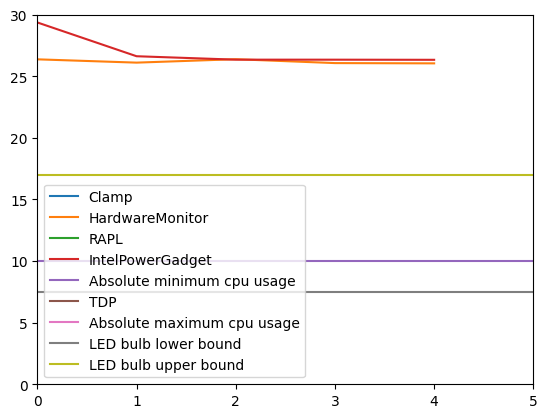

In [14]:
#PlotEnergyConsumption(getTestcase(PowerKomplett,"TestCaseIdle"))
# getTestcaseNames(PowerKomplett)
# PlotEnergyConsumptionPerTestcase(SurfaceBook)
# getTestCaseEnergyStats(Surface4Pro,"TestCaseIdle")

# dut = PowerKomplett
# PlotEnergyConsumptionPerTestcase(dut, sort = False)
#getTestcase(dut,"TestCaseIdleDelay")
#getTestcaseNames(dut)
HardwareMeasure = 5
HardwareMonitor = 3
RAPL = 4
IntelPowerGadget = 1
testCase="TestCaseIdle1secCStateDisabled"
ClampKomplett = getDut(getProfilerData(HardwareMeasure), "PowerKomplett")
HWKomplett = getDut(getProfilerData(HardwareMonitor), "PowerKomplett")
RAPLKomplett=getDut(getProfilerData(RAPL), "PowerKomplett")
IntelKomplett = getDut(getProfilerData(IntelPowerGadget),"PowerKomplett")

m1 = [x/60 for x in getEnergyConsumptionClamp(getTestcase(ClampKomplett,testCase))]
m2 = [x/60 for x in getEnergyConsumptionHW(getTestcase(HWKomplett,testCase))]
m3 = [10 for x in range(0,250)]
m4 = [65 for x in range(0,250)]
m5 = [95 for x in range(0,250)]
m6 = [7.5 for x in range(0,250)]
m7 = [17 for x in range(0,250)]
m8 = [x/60 for x in getEnergyConsumptionRapl(getTestcase(RAPLKomplett,testCase))]
m9 = [x/60 for x in getEnergyConsumptionIntel(getTestcase(IntelKomplett,testCase))]


plt.plot(m1, label = "Clamp")
plt.plot(m2, label = "HardwareMonitor")
plt.plot(m8, label = "RAPL")
plt.plot(m9, label = "IntelPowerGadget")
plt.plot(m3, label = "Absolute minimum cpu usage")
plt.plot(m4, label = "TDP")
plt.plot(m5, label = "Absolute maximum cpu usage")
plt.plot(m6, label = "LED bulb lower bound")
plt.plot(m7, label = "LED bulb upper bound")

plt.title = testCase
plt.ylim([0,30]);
plt.xlim([0,5])
plt.legend()
plt.show()

In [8]:
ClampStat = getTestCaseEnergyStats([x/60 for x in getEnergyConsumptionClamp(getTestcase(ClampKomplett,testCase))])
HWState = getTestCaseEnergyStats([x/60 for x in getEnergyConsumptionHW(getTestcase(HWKomplett,testCase))])
#RAPLState = getTestCaseEnergyStats([x/60 for x in getEnergyConsumptionRapl(getTestcase(RAPLKomplett,testCase))])

print(f"Clamp min: {ClampStat[0]}, max: {ClampStat[1]} avg: {ClampStat[3]} std: {ClampStat[2]}")
print(f"HW min: {HWState[0]}, max: {HWState[1]} avg: {HWState[3]} std: {HWState[2]}")
#print(f"RAPL min: {RAPLState[0]}, max: {RAPLState[1]} avg: {RAPLState[3]}")

Clamp min: 62.61761737342835, max: 143.7017839903715 avg: 111.97162040986943 std: 9.644136888071142
HW min: 57.95402186711629, max: 67.20471404393514 avg: 60.41797303467794 std: 1.3008435542357972


In [10]:
#PlotEnergyConsumptionPerTestcase(HWKomplett)
getTestcaseNames(ClampKomplett)

{'BinaryTrees',
 'DiningPhilosophers',
 'FannkuchRedux',
 'Fasta',
 'Nbody',
 'TestCaseIdle',
 'TestCaseIdle1secCStateDisabled',
 'TestCaseIdleCStateDisabled',
 'TestCaseIdleDelay'}